In [1]:
from pkg_req import *
from construction import *
from solver import *
from backend import *
from pulses import *
from fidelity import *

In [3]:
#test params
dim = 3
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9
v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9
J = 0.002e9
dt= 1/4.5e9
sigma = 128
angle=np.pi/3
num_samples = 200
shots=10000

In [5]:
#Operators defined
H=hamiltonian(dim, v0, v1, anharm0, anharm1, J)
drive_op0=driveop(dim, r0)
drive_op1=driveop(dim, r1)

#solver
solver, solver_options=dynam_solver(H, drive_op0, drive_op1, v0, v1, dt)

#backend
backend=dynam_backend(solver, solver_options, dim)

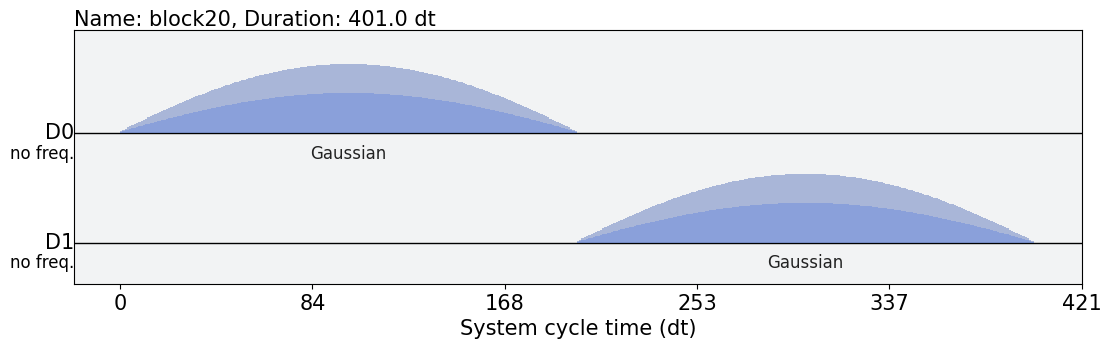

In [14]:
#Arbitrary simple pulse circuit for 2 qubits
schedules = []
dat=[]
for i in range(0,1,1):
    for amp in np.linspace(0.5, 1,1):
        gauss1 = pulse.library.Gaussian(num_samples, amp, sigma, angle)
        gauss2 = pulse.library.Gaussian(num_samples, amp, sigma+0.6, angle*2)
        with pulse.build(backend=backend) as schedule:
            with pulse.align_sequential():
                pulse.play(gauss1, pulse.DriveChannel(0))
                #pulse.shift_phase(0.3, pulse.DriveChannel(1))
                #pulse.shift_frequency(0.1, pulse.DriveChannel(0))
                pulse.play(gauss, pulse.DriveChannel(1))
                #pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))
                #pulse.measure_channel(0)
                pulse.measure_all()
    
        schedules.append(schedule)
schedules[0].draw()

In [18]:
#Run simulation
job = backend.run(schedules, shots=shots)
result = job.result()
counts=result.get_counts(0)
print(counts)

{np.str_('00'): np.int64(4100), np.str_('01'): np.int64(89), np.str_('10'): np.int64(5772), np.str_('11'): np.int64(39)}


In [40]:
#Probability of getting each state
probabilities = {state: count / shots for state, count in counts.items()}
probabilities

{np.str_('00'): np.float64(0.41),
 np.str_('01'): np.float64(0.0089),
 np.str_('10'): np.float64(0.5772),
 np.str_('11'): np.float64(0.0039)}

In [41]:
#Identify what state we want the fidelity of
ideal_density_matrix = np.zeros((4, 4), dtype=complex)
ideal_density_matrix[0, 0] = 1  # Pure state |00>

In [39]:
#Verifying it works since we should get back the same probability as above for |00>
calculate_fidelity(counts, ideal_density_matrix)

0.41000000000000003

In [44]:
ideal_density_matrix = np.zeros((4, 4), dtype=complex)
ideal_density_matrix[0, 0] = 0.5  # 50% probability for |00>
ideal_density_matrix[3, 3] = 0.5  # 50% probability for |11>
calculate_fidelity(counts, ideal_density_matrix)

0.24693749804626441